## Detección de Out-of-Distribution (OOD)
La comprobación de los elementos fuera de distribución, es decir, de imágenes que no pertenezcan al dataset utilizado, es un elemento crucial para el despliegue de sistemas de Machine-Learning, concretamente, los sistemas no supervisados.

En este código, vamos a implementar la metodología del paper "Denoising diffusion models for out-of-distribution detection" para la detección de estas imágenes.

# Importación de Librerías

In [1]:
import torch
from torch.nn import functional as F
from diffusers import PNDMScheduler, UNet2DModel
# from diffusers import schedulers
# from PIL import Image

import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms

# Funciones auxiliares necesarias

In [2]:
def show_images(images_tensor:torch.tensor, cmap = "grey"):
    n_dims = images_tensor.dim()
    
    if n_dims in (2,3):
        x_cat = images_tensor

    elif n_dims == 4:
        x_list = [img for img in images_tensor]
        x_cat = torch.cat(x_list,dim=2)
    
    else:
        raise SyntaxError("The dimensions of images_tensor must be between 2 and 4")

    if n_dims != 2:
        if x_cat.shape[0] == 1:
            plt.imshow(x_cat.movedim(0,-1),cmap);
        else:
            plt.imshow(x_cat.movedim(0,-1));
    else:
        plt.imshow(x_cat,cmap);

In [3]:
def show_images_list(images_list:list[torch.Tensor], cmap = "grey") -> None:

    images_tensor = torch.concat(images_list,dim=0)

    # return images_tensor
    # show_images(images_tensor.unsqueeze(1))
    show_images(images_tensor.unsqueeze(1),cmap)


# Dataset
Usaremos fashionMNIST como dataset de datos En Distribución (ID) y sus versiones Volteadas como dataset Fuera de Distribución (OOD)

De momento, solamente vamos a entrenar a la red, por lo que no necesitaremos las distribuciones OOD

## Imágenes del para el dataset original: FashionMNIST

In [4]:
preprocess = transforms.Compose([
    transforms.ToTensor(),              #To Torch Tensor
    transforms.Pad(2),                  # Add a padding of 2 pixels
    transforms.Normalize([0.5], [0.5])  # Normalize to (-1,1)
])

def dataset_preprocess(examples):
    images = [preprocess(example) for example in examples["image"]]
    return {"image": images}

In [5]:
dataset = load_dataset("fashion_mnist")

_,test_dataset = torch.utils.data.random_split(dataset["train"].with_transform(dataset_preprocess),(0.8,0.2))

# val_dataset = torch.utils.data.random_split(dataset["test"].with_transform(dataset_preprocess),(1,))[0]


In [6]:
# train_dataloader = torch.utils.data.DataLoader(
#     train_dataset,
#     shuffle=True,
#     batch_size=256
# )
ID_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    shuffle=True,
    batch_size=256
)
# val_dataloader = torch.utils.data.DataLoader(
#     val_dataset,
#     shuffle=True,
#     batch_size=256
# )

## Imágenes del para el dataset de pruebas: FashionMNIST volteado verticalmente

In [7]:
OOD_preprocess = transforms.Compose([
    transforms.ToTensor(),              #To Torch Tensor
    transforms.RandomVerticalFlip(1),   # Vertical flip all the images
    transforms.Pad(2),                  # Add a padding of 2 pixels
    transforms.Normalize([0.5], [0.5])  # Normalize to (-1,1)
])

def dataset_OOD_preprocess(examples):
    images = [OOD_preprocess(example) for example in examples["image"]]
    return {"image": images}

In [8]:
OOD_dataset,_ = torch.utils.data.random_split(dataset["train"].with_transform(dataset_OOD_preprocess),(0.5,0.5))

OOD_dataloader = torch.utils.data.DataLoader(
    OOD_dataset,
    shuffle=True,
    batch_size=256
)

In [ ]:
# dataset_ood = load_dataset("MNIST")

In [ ]:
# OOD_dataset,_ = torch.utils.data.random_split(dataset_ood["train"].with_transform(dataset_preprocess),(0.5,0.5))
# OOD_dataloader = torch.utils.data.DataLoader(
#     OOD_dataset,
#     shuffle=True,
#     batch_size=256
# )

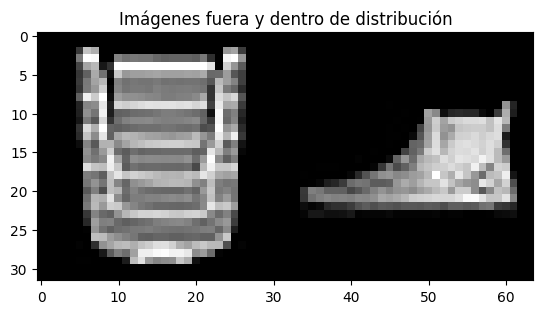

In [9]:
# show_images(next(iter(OOD_dataloader))["images"][5])

show_images_list([next(iter(OOD_dataloader))["image"][5], next(iter(ID_dataloader))["image"][5]])
plt.title("Imágenes fuera y dentro de distribución");

## Lectura de datos de base
Vamos a leer los datos de la distribución formada por las métricas para poder realizar el cálculo de los z-scores más adelante

In [10]:
import csv
MSE_distribution_list = []
LPIPS_distribution_list = []

with open("Base_data_distribution.csv","r") as file:

    reader = csv.reader(file)

    for row in reader:
        if row[0] == "MSE_distribution":
            MSE_distribution_list.append(tuple([float(item) for item in row[1:]]))
        
        elif row[0] == "LPIPS_distribution":
            LPIPS_distribution_list.append(tuple([float(item) for item in row[1:]]))

        else:
            raise ValueError("No se encuentra el nombre del tipo de dato en la primera columna")

# Modelo
Importamos el Modelo del fichero de pesos

In [11]:
base_model = UNet2DModel(
    in_channels=1,  # 1 channels for grey scale
    out_channels=1,
    sample_size=32,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(32, 64, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
        ),

).cuda()

base_model.load_state_dict(torch.load("Base_model_OOD_detection.pth",weights_only=True))
base_model.eval()

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [12]:
def new_scheduler(num_timesteps:int):
    scheduler = PNDMScheduler(
        num_train_timesteps=1000, beta_start=0.0015, beta_end=0.0195
    )
    scheduler.set_timesteps(num_timesteps)# Especificamos el nº de pasos de inferencia que usaremos

    return scheduler

scheduler = new_scheduler(50)

# Generación de imágenes

In [13]:
def PNDM_generation_loop(input_img:torch.Tensor, input_timestep : int, model: UNet2DModel, scheduler : PNDMScheduler):

    if input_img.dim() != 4:     # Control de Errores
        raise SyntaxError("Error de Dimensiones. El Tensor de entrada dbe tener 4 dimensions, siendo la primera la dimensión de lote")
    
    noisy_x = input_img

    if input_timestep < 0 or input_timestep > 1000: # Control de Errores
        raise SyntaxError("El timestep debe estar entre 0 y 1000")
    
    if input_timestep == 1000:  # Si el Timestep es de 1000, se genera una imagen desde cero
        idx = 0
    else:                       # Si no es de 1000, se comienza desde el punto correspondiente, con los datos de la imagen deseada
        idx = torch.where(scheduler.timesteps == input_timestep)[0][0]  # Buscamos el indice del timestep en la lista del scheduler

    for t in scheduler.timesteps[idx:]:     # Iteramos sobre la lista del scheduler. Cada elemento es uno de los timesteps de la cadena

        with torch.inference_mode():        # Realizamos un paso de la iteración
            noise_pred = model(noisy_x, t,return_dict=False)[0]

        scheduler_output = scheduler.step(noise_pred, t, noisy_x)   # Paso del scheduler

        noisy_x = scheduler_output.prev_sample                      # Realimentamos el bucle
    
    return(scheduler_output.prev_sample)  # Devolvemos el resultado.

# Métricas

In [14]:
from torchmetrics.functional import mean_squared_error as MSE
from torchmetrics.functional.image.lpips import learned_perceptual_image_patch_similarity as LPIPS

In [15]:
def prepare_to_lpips(img:torch.tensor): # Prepara una imagen para poder realizar una métrica de LPIPS: size(N, 3, H, W) y valores entre -1 y 1

    max,min = img.max(),img.min()
    normalized =  2* ( ((img-min) / (max-min)) - 0.5)

    output = normalized.repeat(1,3,1,1)

    return output

# Detección de OODs
1. Obtenemos una imagen de cada dataset, OOD e ID (FashionMNIST volteado verticalmente y FashionMNIST)
2. Realizamos las N restauraciones de la imagen.
    * Generamos ruido gaussiano
    * Añadimos el ruido según los timesteps dados
    * Realizamos la restauración con nuestra red
    * Calculamos las métricas
3. Calculamos el z-score con los datos recopilados anteriormente
4. Promediamos los z-scores

5. Comparamos los z-scores para averiguar si la imagen pertenece o no al dataset

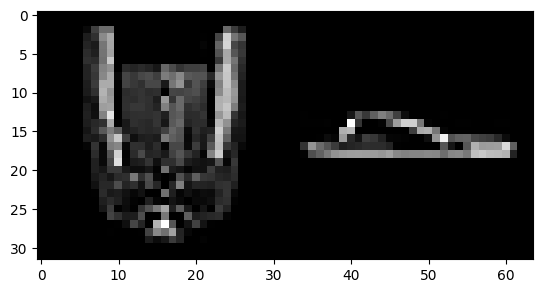

In [16]:
OOD_img = next(iter(OOD_dataloader))["image"][0].cuda()
ID_img = next(iter(ID_dataloader))["image"][0].cuda()
show_images_list([OOD_img.cpu(), ID_img.cpu()])

In [17]:
N = 50      # Número de restauraciones que se realizarán

# noise_a = torch.randn_like(OOD_img)
# noise_b = torch.randn_like(ID_img)

timesetps = torch.arange(1000,0,(0-1000)/N,dtype=torch.int)

In [18]:
def OOD_detection_restoration(img : torch.Tensor, timesetps:torch.Tensor):

    scheduler = new_scheduler(50)

    img = img.cuda()
    if img.dim() != 4:
        raise SyntaxError("Error: Las imágenes deben tener dimensión de lote (batch dimension)")

    restored_images = []
    MSE_base_list = []
    LPIPS_base_list = []

    lpips_img = prepare_to_lpips(img)

    for step in timesetps:
        
        noise = torch.randn_like(img)
        if step == 1000:
            new_imgs = noise
        else:
            new_imgs = scheduler.add_noise(img,noise,torch.ones((len(img)),dtype=torch.int)*step)

        restoration = PNDM_generation_loop(new_imgs,step,base_model,scheduler)
        restored_images.append(restoration)

        individual_MSE = []
        individual_LPIPS = []
        
        for idx,imagen in enumerate(restoration):
            individual_MSE.append(MSE(imagen,img[idx]).cpu())

            lpips_restoration = prepare_to_lpips(imagen)
            individual_LPIPS.append(LPIPS(lpips_restoration,lpips_img[idx].unsqueeze(0)).cpu())

        MSE_base_list.append(individual_MSE)
        LPIPS_base_list.append(individual_LPIPS)


    restored_images = torch.stack(restored_images).swapaxes(0,1)
    MSE_base_list = torch.stack([torch.stack(row) for row in MSE_base_list]).swapaxes(0,1)
    LPIPS_base_list = torch.stack([torch.stack(row) for row in LPIPS_base_list]).swapaxes(0,1)

    return (restored_images, MSE_base_list, LPIPS_base_list)

In [ ]:
OOD_restored_images, OOD_MSE_base, OOD_LPIPS_base = OOD_detection_restoration(OOD_img.unsqueeze(0),timesetps)

ID_restored_images, ID_MSE_base, ID_LPIPS_base = OOD_detection_restoration(ID_img.unsqueeze(0),timesetps)

In [ ]:
OOD_MSE_base.shape

In [19]:
def OOD_detection_zscore(MSE_base_list:torch.Tensor, LPIPS_base_list:torch.Tensor):

    # Calculemos ahora el z-score de cada medida

    if MSE_base_list.dim() != 2:
        raise SyntaxError("Error: El Tensor con los datos debe tener 2 dimensiones: Dimensión de lote (batch) y nº de restauraciones")
    if LPIPS_base_list.dim() != 2:
        raise SyntaxError("Error: El Tensor con los datos debe tener 2 dimensiones: Dimensión de lote (batch) y nº de restauraciones")

    if MSE_base_list.shape != LPIPS_base_list.shape:
        raise SyntaxError("Error: Los tensores de entrada deben tener el mismo tamaño")


    MSE_zscore = torch.empty_like(MSE_base_list)
    LPIPS_zscore = torch.empty_like(MSE_base_list)


    for idx_1,data in enumerate(MSE_base_list):
        for idx_2,step_data in enumerate(data):
            mean,std = MSE_distribution_list[idx_2]
            zscore = (abs(step_data-mean))/std
        
            MSE_zscore[idx_1,idx_2] = zscore


    for idx_1,data in enumerate(LPIPS_base_list):
        for idx_2,step_data in enumerate(data):
            mean,std = MSE_distribution_list[idx_2]
            zscore = (abs(step_data-mean))/std
        
            LPIPS_zscore[idx_1,idx_2] = zscore

    OOD_score = torch.stack((MSE_zscore,LPIPS_zscore))

    return (MSE_zscore,LPIPS_zscore, OOD_score.mean((0,2)))

In [ ]:
OOD_MSE_zscore,OOD_LPIPS_zscore,OOD_general_zscore = OOD_detection_zscore(OOD_MSE_base,OOD_LPIPS_base)
ID_MSE_zscore,ID_LPIPS_zscore,ID_general_zscore = OOD_detection_zscore(ID_MSE_base,ID_LPIPS_base)

In [ ]:
OOD_general_zscore

In [ ]:
ID_general_zscore

In [ ]:
show_images(OOD_restored_images.squeeze(0)[::5].cpu())

In [ ]:
show_images(ID_restored_images.squeeze(0)[::5].cpu())

# Vamos a calcular la curva ROC

In [20]:
class labeled_dataset(torch.utils.data.Dataset):

    def __init__(self,dataset:torch.utils.data.Dataset,category:str):
        self.dataset = dataset
        self.category = category

    def __len__(self):
        return(len(self.dataset))
    
    def __getitem__(self, index):
        
        img = self.dataset[index]["image"]
        data = {
            "image" : img,
            "category": self.category
        }
        if type(index) == slice:
            data = {
                "image" : img,
                "category": [self.category for _ in range(len(img))]
            }
        return data
    
    

In [21]:
ID_dataset = labeled_dataset(dataset["train"].with_transform(dataset_preprocess),"ID")
new_OOD_dataset = labeled_dataset(dataset["test"].with_transform(dataset_OOD_preprocess),"OOD")

In [ ]:
# ID_dataset = labeled_dataset(dataset["train"].with_transform(dataset_preprocess),"ID")
# new_OOD_dataset = labeled_dataset(dataset_ood["test"].with_transform(dataset_preprocess),"OOD")

In [22]:
ID_split,_ = torch.utils.data.random_split(ID_dataset,(0.1,0.9))
OOD_split,_ = torch.utils.data.random_split(new_OOD_dataset,(0.6,0.4))
random_dataset = torch.utils.data.ConcatDataset((ID_split,OOD_split))
len(random_dataset)

12000

In [23]:
dataloader = torch.utils.data.DataLoader(
    random_dataset,
    batch_size=100,
    shuffle=True
)

random_data = next(iter(dataloader))

random_data["image"].shape

torch.Size([100, 1, 32, 32])

In [24]:
random_data["category"]

['ID',
 'ID',
 'ID',
 'OOD',
 'OOD',
 'OOD',
 'ID',
 'OOD',
 'ID',
 'ID',
 'OOD',
 'OOD',
 'ID',
 'OOD',
 'ID',
 'OOD',
 'ID',
 'OOD',
 'ID',
 'ID',
 'OOD',
 'OOD',
 'OOD',
 'ID',
 'ID',
 'ID',
 'ID',
 'ID',
 'OOD',
 'ID',
 'ID',
 'OOD',
 'OOD',
 'ID',
 'ID',
 'ID',
 'OOD',
 'ID',
 'OOD',
 'ID',
 'OOD',
 'OOD',
 'ID',
 'OOD',
 'OOD',
 'ID',
 'ID',
 'OOD',
 'OOD',
 'ID',
 'OOD',
 'ID',
 'OOD',
 'ID',
 'ID',
 'ID',
 'OOD',
 'OOD',
 'ID',
 'ID',
 'ID',
 'ID',
 'ID',
 'ID',
 'ID',
 'ID',
 'OOD',
 'OOD',
 'OOD',
 'OOD',
 'ID',
 'OOD',
 'ID',
 'ID',
 'OOD',
 'OOD',
 'OOD',
 'ID',
 'ID',
 'OOD',
 'OOD',
 'ID',
 'OOD',
 'OOD',
 'ID',
 'OOD',
 'ID',
 'ID',
 'ID',
 'OOD',
 'OOD',
 'ID',
 'ID',
 'OOD',
 'ID',
 'OOD',
 'OOD',
 'ID',
 'OOD',
 'OOD']

In [25]:
random_img,random_MSE,random_LPIPS = OOD_detection_restoration(random_data["image"].cuda(),timesetps)

'OOD'

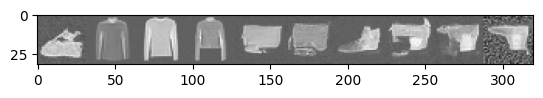

In [27]:
show_images(random_img[3][::5].cpu())
random_data["category"][3]

In [28]:
random_MSE_zscore, random_LPIPS_zscore, random_OOD_score = OOD_detection_zscore(random_MSE,random_LPIPS)
tidy_OOD_scores, tidy_OOD_idx = random_OOD_score.sort(0)

In [29]:
tidy_OOD_scores

tensor([ 5.9599,  5.9999,  6.3823,  6.4122,  6.4807,  6.5578,  6.6445,  6.6527,
         6.6775,  6.7230,  6.7376,  6.7408,  6.7781,  6.7791,  6.7800,  6.8818,
         6.9303,  7.0207,  7.0279,  7.0409,  7.0465,  7.0516,  7.0664,  7.0735,
         7.0809,  7.0884,  7.0946,  7.1037,  7.2441,  7.2574,  7.2583,  7.2653,
         7.2725,  7.2752,  7.3012,  7.3228,  7.3353,  7.3375,  7.3852,  7.4091,
         7.4380,  7.5933,  7.6453,  7.6546,  7.6607,  7.7249,  7.7467,  7.8019,
         7.8678,  7.8892,  7.9048,  7.9265,  8.0334,  8.0342,  8.0359,  8.0898,
         8.0971,  8.1806,  8.2604,  8.2649,  8.3140,  8.3946,  8.4764,  8.5098,
         8.5194,  8.5830,  8.5883,  8.5962,  8.6811,  8.6871,  8.6953,  8.7149,
         8.7694,  8.7950,  8.8342,  8.8893,  8.9144,  8.9699,  8.9891,  9.0794,
         9.2507,  9.4974,  9.7591,  9.7743,  9.7816,  9.8442, 10.0902, 10.1932,
        10.2453, 10.6298, 10.7734, 10.8389, 11.2293, 11.5019, 11.5255, 11.6054,
        11.6812, 11.8825, 13.1061, 15.65

In [30]:
TPR = []    # Tasa de Verdaderos Positivos 
FPR = []    # Tasa de Falsos Positivos 

for idx in range(len(tidy_OOD_idx)):
    
    ID_idx     = tidy_OOD_idx[:idx]
    
    OOD_idx     = tidy_OOD_idx[idx:]

    True_OOD = 0
    False_OOD = 0
    True_ID = 0
    False_ID = 0
    
    for index in OOD_idx:
        True_OOD += int(random_data["category"][index] == "OOD")
        False_OOD += int(random_data["category"][index] == "ID")


    for index in ID_idx:
        True_ID += int(random_data["category"][index] == "ID")
        False_ID += int(random_data["category"][index] == "OOD")

    TPR_data = True_OOD/(True_OOD+False_ID)
    TPR.append(TPR_data)

    FPR_data = False_OOD/(False_OOD+True_ID)
    FPR.append(FPR_data)

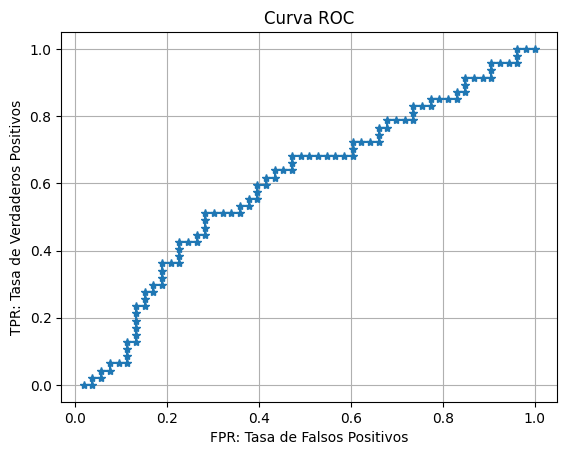

In [31]:
plt.plot(FPR,TPR, "*-")
plt.grid()
plt.xlabel("FPR: Tasa de Falsos Positivos");
plt.ylabel("TPR: Tasa de Verdaderos Positivos");
plt.title("Curva ROC");

In [32]:
from sklearn.metrics import auc
auc(FPR,TPR)

0.5949417904456041